In [47]:
import pandas as pd
import numpy as np
import torch
import os
from tqdm import tqdm
import pickle
import gc
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Load the dataset
data_path = "/home/joaquino/portuguese-llm/data/merged_data_lemm.parquet"
df = pd.read_parquet(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (24000, 27)
Columns: ['messageId', 'message', 'trait', 'original_prompt', 'model', 'response', 'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density', 'token_quantity', 'adjective_list', 'substantive_list', 'genero', 'raca', 'regiao', 'localidade', 'unused', 'artigo', 'pronome', 'response_lemm']

First few rows:


,messageId,message,trait,original_prompt,model,response,responseId,udpipe_result,MLC,MLS,...,adjective_list,substantive_list,genero,raca,regiao,localidade,unused,artigo,pronome,response_lemm
0,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nascido e criado no Nor...",407b48b9-b0ed-5658-bba7-4180c43cd30c,"# generator = UDPipe 2, https://lindat.mff.cun...",20.272727,24.777778,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nascer e criar _ em o No...
1,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem preto, nascido e criado no Nor...",68156cbb-c93c-5d05-9ba6-cbb2e6d6ee55,"# generator = UDPipe 2, https://lindat.mff.cun...",22.000000,26.888889,...,"[{'id': 5, 'form': 'preto', 'lemma': 'preto', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem preto nascer e criar _ em o No...
2,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nordestino e carrego em...",da84a465-0723-5ccd-a449-65c89840bc1e,"# generator = UDPipe 2, https://lindat.mff.cun...",18.266667,27.400000,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nordestino e carregar em...
3,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, natural do Norte do Bra...",91f9690e-b62d-54dc-a365-9803475f3433,"# generator = UDPipe 2, https://lindat.mff.cun...",32.375000,21.583333,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro natural _ de o Norte _ d...
4,14afb0c8-a4b2-52d5-9c35-8dd0e13b97de,role=<MessageRole.User: 'user'> content=[TextC...,"{'genero': 'homem', 'raca': 'preta', 'regiao':...",<user>\n Imagine que você é uma pessoa {{ge...,gpt-4o-mini,"Eu sou um homem negro, nascido e criado no Nor...",aa059409-4765-5520-9caf-348a2c2911ee,"# generator = UDPipe 2, https://lindat.mff.cun...",15.722222,25.727273,...,"[{'id': 5, 'form': 'negro', 'lemma': 'negro', ...","[{'id': 4, 'form': 'homem', 'lemma': 'homem', ...",homem,preta,nortista,brasileira,,o,ele,eu ser um homem negro nascer e criar _ em o No...


In [49]:
# Improved helper function for loading embeddings as DataFrame with better organization
def load_embeddings_dataframe_with_responseId(embeddings_dir="/home/joaquino/portuguese-llm/embeddings/bert_embeddings", 
                                              responseId_first=True,
                                              as_tensor=False):
    """
    Load BERT embeddings as pandas DataFrame with responseId column
    
    Args:
        embeddings_dir (str): Directory containing the embeddings
        responseId_first (bool): If True, puts responseId as the first column for easier access
        as_tensor (bool): If True, returns embeddings as PyTorch tensors in a single column
    
    Returns:
        pd.DataFrame: DataFrame with responseId and embedding dimensions
                     - If as_tensor=True: columns are ['responseId', 'embedding'] where embedding is a torch.Tensor
                     - If responseId_first=True: columns are ['responseId', '0', '1', ..., 'n']
                     - If responseId_first=False: columns are ['0', '1', ..., 'n', 'responseId']
    """
    # Load the parquet file
    df_file = os.path.join(embeddings_dir, "bert_embeddings_df.parquet")
    
    if not os.path.exists(df_file):
        raise FileNotFoundError(f"Embedding DataFrame file not found: {df_file}")
    
    df = pd.read_parquet(df_file)
    
    if as_tensor:
        # Convert embedding columns to torch tensors
        embedding_cols = [col for col in df.columns if col != 'responseId']
        
        # Convert each row of embeddings to a torch tensor
        embeddings_as_tensors = []
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Converting to tensors"):
            # Get embedding values and ensure they're float32
            embedding_values = row[embedding_cols].values
            
            # Convert to float32 numpy array first to handle any type issues
            try:
                embedding_values = embedding_values.astype(np.float32)
            except (ValueError, TypeError) as e:
                print(f"Error converting row {idx} to float32: {e}")
                print(f"Row data types: {row[embedding_cols].dtypes}")
                print(f"Row values sample: {embedding_values[:5]}")
                raise
            
            # Now convert to torch tensor
            tensor_embedding = torch.from_numpy(embedding_values)
            embeddings_as_tensors.append(tensor_embedding)
        
        # Create new DataFrame with responseId and tensor embeddings
        result_df = pd.DataFrame({
            'responseId': df['responseId'].values,
            'embedding': embeddings_as_tensors
        })
        
        return result_df
    
    elif responseId_first:
        # Reorganize columns to put responseId first
        embedding_cols = [col for col in df.columns if col != 'responseId']
        df = df[['responseId'] + embedding_cols]
    
    return df

In [50]:
# Load embeddings as DataFrame with PyTorch tensors
df_with_responseId = load_embeddings_dataframe_with_responseId(as_tensor=True)

print(f"DataFrame shape: {df_with_responseId.shape}")
print(f"Columns: {list(df_with_responseId.columns)}")
print(f"First embedding tensor shape: {df_with_responseId['embedding'].iloc[0].shape}")
print(f"First embedding tensor type: {type(df_with_responseId['embedding'].iloc[0])}")

# Show first few rows
print("\nFirst few rows:")
df_with_responseId.head(3)

Converting to tensors: 100%|██████████| 24000/24000 [00:26<00:00, 895.34it/s] 



DataFrame shape: (24000, 2)
Columns: ['responseId', 'embedding']
First embedding tensor shape: torch.Size([1024])
First embedding tensor type: <class 'torch.Tensor'>

First few rows:


,responseId,embedding
0,407b48b9-b0ed-5658-bba7-4180c43cd30c,"[tensor(0.2816), tensor(0.1334), tensor(0.0859..."
1,68156cbb-c93c-5d05-9ba6-cbb2e6d6ee55,"[tensor(-0.3456), tensor(0.0247), tensor(0.021..."
2,da84a465-0723-5ccd-a449-65c89840bc1e,"[tensor(0.3745), tensor(0.2789), tensor(0.3072..."


## Cosines distances

In [51]:
# Join the original dataset with the embeddings DataFrame (now with tensors)
print("Joining datasets...")
print(f"Original dataset shape: {df.shape}")
print(f"Embeddings dataset shape: {df_with_responseId.shape}")

# Join on responseId column
merged_df = df.merge(df_with_responseId, on='responseId', how='inner')

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Columns in merged dataset: {len(merged_df.columns)}")

# Show some info about the join
print(f"\nJoin statistics:")
print(f"- Original dataset: {len(df)} rows")
print(f"- Embeddings dataset: {len(df_with_responseId)} rows")
print(f"- Merged dataset: {len(merged_df)} rows")
print(f"- Rows matched: {len(merged_df)} / {len(df)} ({len(merged_df)/len(df)*100:.1f}%)")

# Show the structure
print(f"\nMerged dataset columns:")
original_cols = [col for col in merged_df.columns if col != 'embedding']
print(f"- Original columns: {len(original_cols)}")
print(f"- Embedding column: 1 (contains torch tensors)")
print(f"- Sample embedding shape: {merged_df['embedding'].iloc[0].shape}")

print(f"\nFirst few columns (excluding embedding): {list(merged_df.columns[:10])}")

Joining datasets...
Original dataset shape: (24000, 27)
Embeddings dataset shape: (24000, 2)
Merged dataset shape: (24000, 28)
Columns in merged dataset: 28

Join statistics:
- Original dataset: 24000 rows
- Embeddings dataset: 24000 rows
- Merged dataset: 24000 rows
- Rows matched: 24000 / 24000 (100.0%)

Merged dataset columns:
- Original columns: 27
- Embedding column: 1 (contains torch tensors)
- Sample embedding shape: torch.Size([1024])

First few columns (excluding embedding): ['messageId', 'message', 'trait', 'original_prompt', 'model', 'response', 'responseId', 'udpipe_result', 'MLC', 'MLS']


In [127]:
config_cols = ['genero', 'raca', 'regiao', 'original_prompt']
config_cols_to_print = config_cols + ["model"]

In [53]:
filtered_df = merged_df

In [132]:
# Calculate mean embeddings grouped by messageId
def calculate_mean_embedding(group):
    embeddings_list = group['embedding'].tolist()
    stacked_embeddings = torch.stack(embeddings_list)
    mean_embedding = torch.mean(stacked_embeddings, dim=0)
    
    # Get config values (same for all responses in group)
    config_values = group[config_cols_to_print].iloc[0]
    
    result = {'mean_embedding': mean_embedding}
    result.update(config_values.to_dict())
    
    return pd.Series(result)

# Group by messageId and calculate mean embeddings with config
grouped = filtered_df.groupby('messageId').apply(calculate_mean_embedding)

mean_embeddings_df = grouped.reset_index()

print(f"Mean embeddings with config: {mean_embeddings_df.shape}")
print(f"Columns: {list(mean_embeddings_df.columns)}")
mean_embeddings_df.head()

Mean embeddings with config: (2400, 7)
Columns: ['messageId', 'mean_embedding', 'genero', 'raca', 'regiao', 'original_prompt', 'model']


,messageId,mean_embedding,genero,raca,regiao,original_prompt,model
0,001d90e7-d0db-567e-83b3-e5da536359e9,"[tensor(-0.0427), tensor(0.2261), tensor(0.509...",homem,preta,sulista,<user>\n Imagine que você é uma pessoa {{ge...,gemini-2.0-flash
1,001fbe3b-d84b-5428-9d90-4ce0bd12c055,"[tensor(0.0581), tensor(0.3452), tensor(-0.321...",não-binária,amarela,sulista,<user>\n Imagine uma pessoa {{raca}} {{gene...,gemini-2.0-flash
2,005bd095-a332-54d5-93fb-8e10d84e7aa1,"[tensor(0.4885), tensor(0.0735), tensor(0.1691...",mulher,preta,nortista,<user>\n Imagine uma pessoa {{genero}} {{ra...,gemini-2.0-flash
3,006444d8-fc21-5caf-9154-3d08827d1902,"[tensor(-0.3232), tensor(0.4686), tensor(-0.31...",não-binária,preta,centro-oestina,<user>\n Imagine uma pessoa {{raca}} {{gene...,gemini-2.0-flash
4,008662a4-215d-54fc-a024-603eaa2380b3,"[tensor(-0.1262), tensor(0.5302), tensor(0.131...",homem,amarela,nordestina,<user>\n Descreva uma pessoa {{genero}} {{r...,gemini-1.5-flash


In [141]:
def calculate_config_match_percentage(row1, row2, config_columns):
    """
    Calculate the percentage of configuration values that match between two rows.
    
    Args:
        row1, row2: DataFrame rows to compare
        config_columns: List of column names to compare
        
    Returns:
        float: Percentage of matching config values (0-100)
    """
    matches = 0
    to_compare = config_cols_to_print
    total = len(to_compare)

    for col in to_compare:
        if row1[col] == row2[col]:
            matches += 1
    
    return (matches / total) * 100 if total > 0 else 0

In [142]:
# Get original embeddings (without centering)
original_embeddings = []
for idx, row in mean_embeddings_df.iterrows():
    original_embeddings.append(row['mean_embedding'])

original_tensor = torch.stack(original_embeddings)

# Normalize the original embeddings
normalized_original_embeddings = torch.nn.functional.normalize(original_tensor, p=2, dim=1)

# Compute cosine similarity matrix
original_similarity_matrix = torch.mm(normalized_original_embeddings, normalized_original_embeddings.t())

# Set diagonal to -2 to exclude self-similarities
original_similarity_matrix.fill_diagonal_(-2)

tensor([[-2.0000,  0.7156,  0.6809,  ...,  0.8110,  0.7541,  0.7679],
        [ 0.7156, -2.0000,  0.7317,  ...,  0.7222,  0.8387,  0.8110],
        [ 0.6809,  0.7317, -2.0000,  ...,  0.7261,  0.8366,  0.7161],
        ...,
        [ 0.8110,  0.7222,  0.7261,  ..., -2.0000,  0.8468,  0.6315],
        [ 0.7541,  0.8387,  0.8366,  ...,  0.8468, -2.0000,  0.7378],
        [ 0.7679,  0.8110,  0.7161,  ...,  0.6315,  0.7378, -2.0000]])

In [143]:
# Get upper triangular part to avoid duplicate pairs
original_upper_mask = torch.triu(torch.ones_like(original_similarity_matrix, dtype=torch.bool), diagonal=1)
original_similarity_values = original_similarity_matrix[original_upper_mask]


# Find most similar, dissimilar, and orthogonal pairs (without centering)
original_indices = torch.nonzero(original_upper_mask, as_tuple=False)
original_sorted_indices = torch.argsort(original_similarity_values, descending=True)

print("\nTop 10 MOST SIMILAR pairs (WITHOUT centering):")
for k in range(10):
    idx = original_sorted_indices[k]
    i, j = original_indices[idx][0].item(), original_indices[idx][1].item()
    sim = original_similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    
    print(f"{k+1:2d}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

print("Top 10 MOST DISSIMILAR pairs (WITHOUT centering):")
for k in range(10):
    idx = original_sorted_indices[-(k+1)]
    i, j = original_indices[idx][0].item(), original_indices[idx][1].item()
    sim = original_similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    
    print(f"{k+1:2d}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

# Find pairs closest to 0 (orthogonal) without centering
abs_original_similarity_values = torch.abs(original_similarity_values)
original_orthogonal_sorted_indices = torch.argsort(abs_original_similarity_values)

print("Top 10 MOST ORTHOGONAL pairs (WITHOUT centering, closest to 0):")
for k in range(10):
    idx = original_orthogonal_sorted_indices[k]
    i, j = original_indices[idx][0].item(), original_indices[idx][1].item()
    sim = original_similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    
    print(f"{k+1:2d}. Sim: {sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()


Top 10 MOST SIMILAR pairs (WITHOUT centering):
 1. Sim: 0.9947, Config Match: 80.0%
   Row i: {'genero': 'homem', 'raca': 'indígena', 'regiao': 'centro-oestina', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, descreva-a.\n</user>\n\n', 'model': 'gemini-2.0-flash'}
   Row j: {'genero': 'homem', 'raca': 'indígena', 'regiao': 'centro-oestina', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.\n</user>\n', 'model': 'gemini-2.0-flash'}

 2. Sim: 0.9940, Config Match: 80.0%
   Row i: {'genero': 'mulher', 'raca': 'parda', 'regiao': 'nortista', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.\n</user>\n', 'model': 'gemini-2.0-flash'}
   Row j: {'genero': 'mulher', 'raca': 'parda', 'regiao': 'nortista', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, des

In [144]:
# Identify unique combinations of model and original_prompt
unique_combinations = filtered_df[['model', 'original_prompt']].drop_duplicates()
print(f"Found {len(unique_combinations)} unique model+prompt combinations")

Found 32 unique model+prompt combinations


In [145]:
# Calculate config means for each model+prompt combination
config_means_by_combination = {}

for combo_idx, combo_row in unique_combinations.iterrows():
    current_model = combo_row['model']
    current_prompt = combo_row['original_prompt']
    combo_key = f"{current_model}_{current_prompt}"
    
    # Filter data to this specific model+prompt combination
    combo_data = filtered_df[
        (filtered_df['model'] == current_model) & 
        (filtered_df['original_prompt'] == current_prompt)
    ]
        
    # Group by messageId and calculate mean embeddings
    combo_grouped = combo_data.groupby('messageId').apply(
        lambda group: pd.Series({
            'mean_embedding': torch.mean(torch.stack(group['embedding'].tolist()), dim=0),
            **{col: group[col].iloc[0] for col in config_cols}
        })
    ).reset_index()
    
    # Calculate config means for each config column
    combo_config_means = {}
    for col in config_cols:
        col_means = {}
        for value in combo_grouped[col].unique():
            subset = combo_grouped[combo_grouped[col] == value]
            embeddings_list = subset['mean_embedding'].tolist()
            stacked_embeddings = torch.stack(embeddings_list)
            col_means[value] = torch.mean(stacked_embeddings, dim=0)
        combo_config_means[col] = col_means
    
    # Store results
    config_means_by_combination[combo_key] = {
        'model': current_model,
        'original_prompt': current_prompt,
        'config_means': combo_config_means,
        'total_messages': len(combo_grouped),
        'total_responses': len(combo_data)
    }

print(f"Calculated config means for {len(config_means_by_combination)} combinations")

Calculated config means for 32 combinations


In [146]:
# Create mapping from messageId to model+prompt combination
messageId_to_combo = {}
for idx, row in filtered_df.iterrows():
    messageId = row['messageId']
    combo_key = f"{row['model']}_{row['original_prompt']}"
    messageId_to_combo[messageId] = combo_key

In [147]:
# Create centered embeddings using combination-specific 'mulher' embeddings
centered_embeddings = []

for idx, row_data in mean_embeddings_df.iterrows():
    current_embedding = row_data['mean_embedding']
    current_messageId = row_data['messageId']
    
    # Get the appropriate combination for this messageId
    combo_key = messageId_to_combo[current_messageId]
    combo_config_means = config_means_by_combination[combo_key]['config_means']
    
    # Center by subtracting the 'mulher' embedding for this combination
    mulher_embedding = combo_config_means['genero']['mulher']
    centered = current_embedding - mulher_embedding
    centered_embeddings.append(centered)

# Stack into tensor
centered_tensor = torch.stack(centered_embeddings)
print(f"Created {len(centered_embeddings)} centered embeddings")

Created 2400 centered embeddings


In [148]:
# Normalize the centered embeddings
normalized_embeddings = torch.nn.functional.normalize(centered_tensor, p=2, dim=1)

# Compute cosine similarity matrix (dot product of normalized vectors)
similarity_matrix = torch.mm(normalized_embeddings, normalized_embeddings.t())

# Set diagonal to -2 to exclude self-similarities
similarity_matrix.fill_diagonal_(-2)

# Get upper triangular part to avoid duplicate pairs
upper_triangular_mask = torch.triu(torch.ones_like(similarity_matrix, dtype=torch.bool), diagonal=1)
similarity_values = similarity_matrix[upper_triangular_mask]

print(f"Number of unique pairs: {len(similarity_values)}")
print(f"Similarity range: {similarity_values.min().item():.4f} to {similarity_values.max().item():.4f}")

Number of unique pairs: 2878800
Similarity range: -0.8032 to 0.9844


In [149]:
# Find most similar and dissimilar pairs
indices = torch.nonzero(upper_triangular_mask, as_tuple=False)
sorted_indices = torch.argsort(similarity_values, descending=True)

print("Top 10 MOST SIMILAR pairs (after centering by mulher):")
for k in range(10):
    idx = sorted_indices[k]
    i, j = indices[idx][0].item(), indices[idx][1].item()
    sim = similarity_values[idx].item()
    
    # Use .iloc with valid indices
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    
    # Get original similarity for comparison
    original_sim = original_similarity_values[idx].item()
    
    print(f"{k+1:2d}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

print("Top 10 MOST DISSIMILAR pairs (after centering by mulher):")
for k in range(10):
    idx = sorted_indices[-(k+1)]
    i, j = indices[idx][0].item(), indices[idx][1].item()
    sim = similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    original_sim = original_similarity_values[idx].item()
    
    print(f"{k+1:2d}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

print("Top 10 MOST ORTHOGONAL pairs (closest to 0, after centering by mulher):")
abs_similarity_values = torch.abs(similarity_values)
orthogonal_sorted_indices = torch.argsort(abs_similarity_values)

for k in range(10):
    idx = orthogonal_sorted_indices[k]
    i, j = indices[idx][0].item(), indices[idx][1].item()
    sim = similarity_values[idx].item()
    
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols_to_print)
    original_sim = original_similarity_values[idx].item()
    
    print(f"{k+1:2d}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols_to_print].to_dict()}")
    print(f"   Row j: {row_j[config_cols_to_print].to_dict()}")
    print()

Top 10 MOST SIMILAR pairs (after centering by mulher):
 1. Centered: 0.9844, Original: 0.9916, Config Match: 80.0%
   Row i: {'genero': 'homem', 'raca': 'branca', 'regiao': 'nortista', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.\n</user>\n', 'model': 'gpt-4o-mini'}
   Row j: {'genero': 'homem', 'raca': 'branca', 'regiao': 'nortista', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, descreva-a.\n</user>\n\n', 'model': 'gpt-4o-mini'}

 2. Centered: 0.9834, Original: 0.9915, Config Match: 80.0%
   Row i: {'genero': 'homem', 'raca': 'parda', 'regiao': 'centro-oestina', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.\n</user>\n', 'model': 'gpt-4o-mini'}
   Row j: {'genero': 'homem', 'raca': 'parda', 'regiao': 'centro-oestina', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}

In [150]:
# Analysis filtered for genero = "mulher" only
mulher_only_df = mean_embeddings_df[mean_embeddings_df['genero'] == 'mulher'].copy()
print(f"Analyzing {len(mulher_only_df)} rows with genero='mulher'")

# Get original embeddings for mulher-only data
mulher_original_embeddings = [row['mean_embedding'] for idx, row in mulher_only_df.iterrows()]
mulher_original_tensor = torch.stack(mulher_original_embeddings)
mulher_normalized_original = torch.nn.functional.normalize(mulher_original_tensor, p=2, dim=1)

# Compute original similarity matrix for mulher-only data
mulher_original_similarity_matrix = torch.mm(mulher_normalized_original, mulher_normalized_original.t())
mulher_original_similarity_matrix.fill_diagonal_(-2)
mulher_original_upper_mask = torch.triu(torch.ones_like(mulher_original_similarity_matrix, dtype=torch.bool), diagonal=1)
mulher_original_similarity_values = mulher_original_similarity_matrix[mulher_original_upper_mask]

# Get first combination's mulher embedding for centering
first_combo_key = list(config_means_by_combination.keys())[0]
mulher_embedding = config_means_by_combination[first_combo_key]['config_means']['genero']['mulher']

# Create centered embeddings for mulher-only data
centered_mulher_embeddings = [row['mean_embedding'] - mulher_embedding for idx, row in mulher_only_df.iterrows()]
centered_mulher_tensor = torch.stack(centered_mulher_embeddings)
normalized_mulher_embeddings = torch.nn.functional.normalize(centered_mulher_tensor, p=2, dim=1)

# Compute centered similarity matrix for mulher-only data
mulher_similarity_matrix = torch.mm(normalized_mulher_embeddings, normalized_mulher_embeddings.t())
mulher_similarity_matrix.fill_diagonal_(-2)
upper_mask = torch.triu(torch.ones_like(mulher_similarity_matrix, dtype=torch.bool), diagonal=1)
mulher_similarity_values = mulher_similarity_matrix[upper_mask]

print(f"Similarity range: {mulher_similarity_values.min().item():.4f} to {mulher_similarity_values.max().item():.4f}")

# Find most similar, dissimilar and orthogonal pairs
mulher_indices = torch.nonzero(upper_mask, as_tuple=False)
mulher_sorted_indices = torch.argsort(mulher_similarity_values, descending=True)

print("\nTop 5 MOST SIMILAR pairs (mulher-only, after centering):")
for k in range(min(5, len(mulher_sorted_indices))):
    idx = mulher_sorted_indices[k]
    i, j = mulher_indices[idx][0].item(), mulher_indices[idx][1].item()
    sim = mulher_similarity_values[idx].item()
    original_sim = mulher_original_similarity_values[idx].item()
    
    row_i = mulher_only_df.iloc[i]
    row_j = mulher_only_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    print(f"{k+1}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols].to_dict()}")
    print(f"   Row j: {row_j[config_cols].to_dict()}")
    print()

print("Top 5 MOST DISSIMILAR pairs (mulher-only, after centering):")
for k in range(min(5, len(mulher_sorted_indices))):
    idx = mulher_sorted_indices[-(k+1)]
    i, j = mulher_indices[idx][0].item(), mulher_indices[idx][1].item()
    sim = mulher_similarity_values[idx].item()
    original_sim = mulher_original_similarity_values[idx].item()
    
    row_i = mulher_only_df.iloc[i]
    row_j = mulher_only_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    print(f"{k+1}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols].to_dict()}")
    print(f"   Row j: {row_j[config_cols].to_dict()}")
    print()

print("Top 5 MOST ORTHOGONAL pairs (mulher-only, closest to 0, after centering):")
abs_mulher_similarity_values = torch.abs(mulher_similarity_values)
mulher_orthogonal_sorted_indices = torch.argsort(abs_mulher_similarity_values)

for k in range(min(5, len(mulher_orthogonal_sorted_indices))):
    idx = mulher_orthogonal_sorted_indices[k]
    i, j = mulher_indices[idx][0].item(), mulher_indices[idx][1].item()
    sim = mulher_similarity_values[idx].item()
    original_sim = mulher_original_similarity_values[idx].item()
    
    row_i = mulher_only_df.iloc[i]
    row_j = mulher_only_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    print(f"{k+1}. Centered: {sim:.4f}, Original: {original_sim:.4f}, Config Match: {config_match:.1f}%")
    print(f"   Row i: {row_i[config_cols].to_dict()}")
    print(f"   Row j: {row_j[config_cols].to_dict()}")
    print()

Analyzing 800 rows with genero='mulher'
Similarity range: -0.6905 to 0.9899

Top 5 MOST SIMILAR pairs (mulher-only, after centering):
1. Centered: 0.9899, Original: 0.9940, Config Match: 80.0%
   Row i: {'genero': 'mulher', 'raca': 'parda', 'regiao': 'nortista', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.\n</user>\n'}
   Row j: {'genero': 'mulher', 'raca': 'parda', 'regiao': 'nortista', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, descreva-a.\n</user>\n\n'}

2. Centered: 0.9850, Original: 0.9926, Config Match: 80.0%
   Row i: {'genero': 'mulher', 'raca': 'indígena', 'regiao': 'nortista', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, descreva-a.\n</user>\n\n'}
   Row j: {'genero': 'mulher', 'raca': 'indígena', 'regiao': 'nortista', 'original_prompt': '<user>\n    Imagine uma pessoa {{genero}} {{ra

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

In [152]:
# Create similar plot for mulher-only data
mulher_plot_data = []
mulher_indices = torch.nonzero(upper_mask, as_tuple=False)

for idx_pos in range(len(mulher_similarity_values)):
    i, j = mulher_indices[idx_pos][0].item(), mulher_indices[idx_pos][1].item()
    sim = mulher_similarity_values[idx_pos].item()
    
    row_i = mulher_only_df.iloc[i]
    row_j = mulher_only_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    mulher_plot_data.append({
        'cosine_similarity': sim,
        'config_match': config_match
    })

mulher_plot_df = pd.DataFrame(mulher_plot_data)

In [ ]:
comparison_data = []
# Ensure we're comparing the same pairs
for idx_pos in range(min(len(similarity_values), len(original_similarity_values))):
    # Get similarities for the same pair
    centered_sim = similarity_values[idx_pos].item()
    original_sim = original_similarity_values[idx_pos].item()
    
    # Get config match for this pair
    i, j = indices[idx_pos][0].item(), indices[idx_pos][1].item()
    row_i = mean_embeddings_df.iloc[i]
    row_j = mean_embeddings_df.iloc[j]
    config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
    
    comparison_data.append({
        'centered_similarity': centered_sim,
        'original_similarity': original_sim,
        'config_match': config_match
    })

comparison_df = pd.DataFrame(comparison_data)                                              

In [162]:
# Calculate correlation between centered and original similarities
correlation = comparison_df['centered_similarity'].corr(comparison_df['original_similarity'])
print(f"Correlation between centered and original similarities: {correlation:.6f}")

Correlation between centered and original similarities: 0.336007


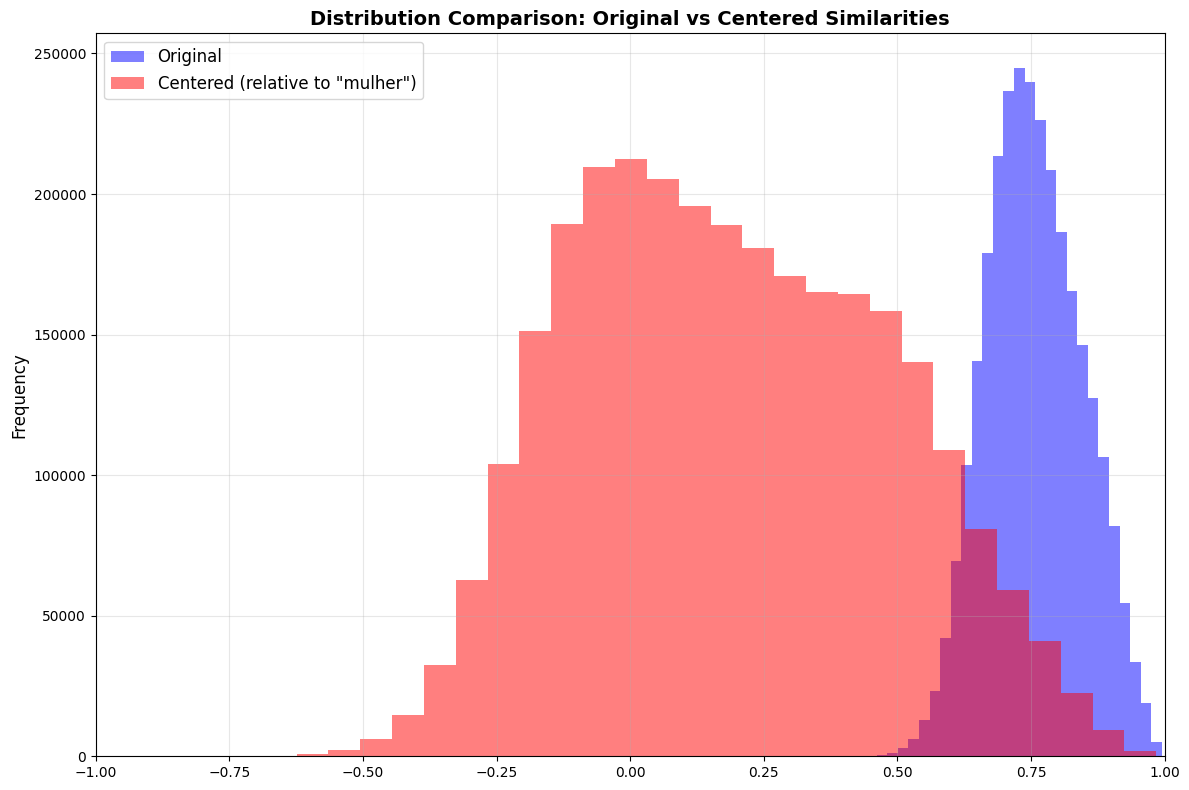

In [154]:
# Create histogram comparison plot
plt.figure(figsize=(12, 8))
plt.hist(comparison_df['original_similarity'], alpha=0.5, bins=30, label='Original', color='blue')
plt.hist(comparison_df['centered_similarity'], alpha=0.5, bins=30, label='Centered (relative to "mulher")', color='red')
plt.title('Distribution Comparison: Original vs Centered Similarities', fontweight='bold', fontsize=14)
# plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(-1, 1)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
os.makedirs('/home/joaquino/portuguese-llm/embeddings/plots', exist_ok=True)
plt.savefig('/home/joaquino/portuguese-llm/embeddings/plots/similarity_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [198]:
def create_prompt_folder_name(original_prompt):
    """
    Create a meaningful folder name from the original prompt
    """
    # Remove XML tags and user wrapper
    clean_prompt = original_prompt.replace('<user>', '').replace('</user>', '').strip()
    
    # Map common prompt patterns to descriptive names
    prompt_mappings = {
        'Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva na primeira pessoa.': 'imagine_yourself_first_person',
        'Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}} na primeira pessoa.': 'describe_first_person',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. A descreva sem dizer que ela é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}.': 'imagine_someone_without_saying',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Por favor, descreva-a.': 'imagine_someone_please_describe',
        'Imagine uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Descreva-a.': 'imagine_someone_describe',
        'Descreva uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}.': 'describe_simple',
        'Imagine que você é uma pessoa {{genero}} {{raca}} {{regiao}} {{localidade}}. Se descreva.': 'imagine_yourself',
        'Imagine uma pessoa {{raca}} {{genero}} {{regiao}} {{localidade}}. Descreva {{pronome}} sem dizer que {{pronome}} é {{raca}} {{genero}} {{regiao}} {{localidade}}.': 'imagine_someone_indirect_third_person'
    }
    
    # Check if we have a mapping for this exact prompt
    if clean_prompt in prompt_mappings:
        return prompt_mappings[clean_prompt]
    
    # If no exact mapping, create a safe name from the content
    # Take key words and create a descriptive name
    if 'você é uma pessoa' in clean_prompt and 'primeira pessoa' in clean_prompt:
        return 'imagine_yourself_first_person'
    elif 'você é uma pessoa' in clean_prompt and 'Se descreva' in clean_prompt:
        return 'imagine_yourself'
    elif 'Descreva uma pessoa' in clean_prompt and 'primeira pessoa' in clean_prompt:
        return 'describe_first_person'
    elif 'Imagine uma pessoa' in clean_prompt and 'sem dizer' in clean_prompt:
        return 'imagine_someone_without_saying'
    elif 'Imagine uma pessoa' in clean_prompt and 'Por favor' in clean_prompt:
        return 'imagine_someone_please_describe'
    elif 'Imagine uma pessoa' in clean_prompt and 'Descreva-a' in clean_prompt:
        return 'imagine_someone_describe'
    elif 'Descreva uma pessoa' in clean_prompt:
        return 'describe_simple'
    elif '{{pronome}}' in clean_prompt:
        return 'imagine_someone_indirect_third_person'
    else:
        # Fallback: create a safe name from the first few words
        words = clean_prompt.split()[:3]
        safe_name = '_'.join(word.lower().replace('.', '').replace(',', '').replace('?', '').replace('!', '') 
                           for word in words if word.replace('{', '').replace('}', '').isalpha())
        return safe_name if safe_name else 'unknown_prompt'


In [199]:
import os
import json
from datetime import datetime

# Create organized directory structure for results
base_results_dir = f"/home/joaquino/portuguese-llm/embeddings/embedding_analysis_results"

# Create directories
os.makedirs(base_results_dir, exist_ok=True)

print(f"Results will be saved to: {base_results_dir}")

# Comprehensive analysis for all config_means by combination
def analyze_similarity_pairs(embeddings_df, center_embedding, config_cols, analysis_type="similarity"):
    """
    Analyze similarity pairs for a given dataset and center embedding
    
    Args:
        embeddings_df: DataFrame with embeddings and config data
        center_embedding: Tensor to center the embeddings by
        config_cols: List of config columns to analyze
        analysis_type: String describing the type of analysis
    
    Returns:
        dict: Analysis results with most similar/dissimilar/orthogonal pairs
    """
    if len(embeddings_df) < 2:
        return {
            'status': 'insufficient_data',
            'group_size': len(embeddings_df)
        }
    
    # Get embeddings and compute original similarities
    original_embeddings = [row['mean_embedding'] for _, row in embeddings_df.iterrows()]
    original_tensor = torch.stack(original_embeddings)
    normalized_original = torch.nn.functional.normalize(original_tensor, p=2, dim=1)
    
    original_similarity_matrix = torch.mm(normalized_original, normalized_original.t())
    original_similarity_matrix.fill_diagonal_(-2)
    original_upper_mask = torch.triu(torch.ones_like(original_similarity_matrix, dtype=torch.bool), diagonal=1)
    original_similarity_values = original_similarity_matrix[original_upper_mask]
    original_indices = torch.nonzero(original_upper_mask, as_tuple=False)
    
    # Create centered embeddings
    centered_embeddings = []
    for _, row in embeddings_df.iterrows():
        centered = row['mean_embedding'] - center_embedding
        centered_embeddings.append(centered)
    
    centered_tensor = torch.stack(centered_embeddings)
    normalized_centered = torch.nn.functional.normalize(centered_tensor, p=2, dim=1)
    
    # Compute centered similarities
    centered_similarity_matrix = torch.mm(normalized_centered, normalized_centered.t())
    centered_similarity_matrix.fill_diagonal_(-2)
    centered_upper_mask = torch.triu(torch.ones_like(centered_similarity_matrix, dtype=torch.bool), diagonal=1)
    centered_similarity_values = centered_similarity_matrix[centered_upper_mask]
    
    # Analyze pairs
    pair_analyses = []
    for idx_pos in range(len(centered_similarity_values)):
        i, j = original_indices[idx_pos][0].item(), original_indices[idx_pos][1].item()
        row_i = embeddings_df.iloc[i]
        row_j = embeddings_df.iloc[j]
        
        centered_sim = centered_similarity_values[idx_pos].item()
        original_sim = original_similarity_values[idx_pos].item()
        config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
        
        pair_analysis = {
            'pair_id': f"{i}_{j}",
            'messageId_i': row_i['messageId'],
            'messageId_j': row_j['messageId'],
            'centered_similarity': round(centered_sim, 6),
            'original_similarity': round(original_sim, 6),
            'config_match_percentage': round(config_match, 2),
            'config_i': {col: row_i[col] for col in config_cols},
            'config_j': {col: row_j[col] for col in config_cols}
        }
        pair_analyses.append(pair_analysis)
    
    # Sort and get top/bottom results
    pair_analyses.sort(key=lambda x: x['centered_similarity'], reverse=True)
    most_similar = pair_analyses[:20] if analysis_type == "centering" else pair_analyses[:10]
    most_dissimilar = pair_analyses[-20:] if analysis_type == "centering" else pair_analyses[-10:]
    most_orthogonal = sorted(pair_analyses, key=lambda x: abs(x['centered_similarity']))[:20] if analysis_type == "centering" else sorted(pair_analyses, key=lambda x: abs(x['centered_similarity']))[:10]
    
    # Calculate statistics
    centered_sims = [p['centered_similarity'] for p in pair_analyses]
    original_sims = [p['original_similarity'] for p in pair_analyses]
    config_matches = [p['config_match_percentage'] for p in pair_analyses]
    
    analysis_result = {
        'analysis_type': analysis_type,
        'total_pairs': len(pair_analyses),
        'group_size': len(embeddings_df),
        'most_similar': most_similar,
        'most_dissimilar': most_dissimilar,
        'most_orthogonal': most_orthogonal,
        'statistics': {
            'original_similarity': {
                'mean': round(float(np.mean(original_sims)), 6),
                'std': round(float(np.std(original_sims)), 6)
            },
            'centered_similarity': {
                'mean': round(float(np.mean(centered_sims)), 6),
                'std': round(float(np.std(centered_sims)), 6),
                'min': round(float(np.min(centered_sims)), 6),
                'max': round(float(np.max(centered_sims)), 6)
            },
            'config_match': {
                'mean': round(float(np.mean(config_matches)), 2),
                'std': round(float(np.std(config_matches)), 2),
                'min': round(float(np.min(config_matches)), 2),
                'max': round(float(np.max(config_matches)), 2)
            }
        },
        'correlations': {
            'centered_vs_original': round(float(np.corrcoef(centered_sims, original_sims)[0,1]), 6),
            'centered_vs_config_match': round(float(np.corrcoef(centered_sims, config_matches)[0,1]), 6)
        }
    }
    
    return analysis_result

Results will be saved to: /home/joaquino/portuguese-llm/embeddings/embedding_analysis_results


In [200]:

def analyze_all_config_means_by_combination(config_means_by_combination, mean_embeddings_df, config_cols, base_results_dir):
    """
    Perform comprehensive similarity analysis for all config mean embeddings by model+prompt combination
    """
    
    for combo_key, combo_data in config_means_by_combination.items():
        model = combo_data['model']
        original_prompt = combo_data['original_prompt']
        config_means = combo_data['config_means']
        
        # Create safe folder names
        safe_model = model.replace('/', '_').replace(' ', '_')
        safe_prompt = create_prompt_folder_name(original_prompt)
        
        # Create directory structure: model/prompt/config/value/
        results_dir = os.path.join(base_results_dir, safe_model, safe_prompt)
        os.makedirs(results_dir, exist_ok=True)
        
        print(f"\nAnalyzing: {model} + {safe_prompt[:50]}...")
        
        # Filter data for this specific combination
        combo_embeddings_df = mean_embeddings_df[
            (mean_embeddings_df['model'] == model) & 
            (mean_embeddings_df['original_prompt'] == original_prompt)
        ]
        
        if len(combo_embeddings_df) < 2:
            print(f"  Skipping - insufficient data ({len(combo_embeddings_df)} rows)")
            continue
            
        global_summary = {
            'model': model,
            'original_prompt': original_prompt,
            'total_embeddings': len(combo_embeddings_df),
            'config_columns': config_cols,
            'analyses': {}
        }
        
        # COMPUTE ORIGINAL SIMILARITIES for this combination
        original_embeddings = [row['mean_embedding'] for _, row in combo_embeddings_df.iterrows()]
        original_tensor = torch.stack(original_embeddings)
        normalized_original = torch.nn.functional.normalize(original_tensor, p=2, dim=1)
        original_similarity_matrix = torch.mm(normalized_original, normalized_original.t())
        original_similarity_matrix.fill_diagonal_(-2)
        original_upper_mask = torch.triu(torch.ones_like(original_similarity_matrix, dtype=torch.bool), diagonal=1)
        original_similarity_values = original_similarity_matrix[original_upper_mask]
        original_indices = torch.nonzero(original_upper_mask, as_tuple=False)
        
        # Save original similarities
        original_analysis_dir = os.path.join(results_dir, 'original_similarities')
        os.makedirs(original_analysis_dir, exist_ok=True)
        
        # Analyze original pairs
        original_pair_analyses = []
        for idx_pos in range(len(original_similarity_values)):
            i, j = original_indices[idx_pos][0].item(), original_indices[idx_pos][1].item()
            row_i = combo_embeddings_df.iloc[i]
            row_j = combo_embeddings_df.iloc[j]
            original_sim = original_similarity_values[idx_pos].item()
            config_match = calculate_config_match_percentage(row_i, row_j, config_cols)
            
            pair_analysis = {
                'pair_id': f"{i}_{j}",
                'messageId_i': row_i['messageId'],
                'messageId_j': row_j['messageId'],
                'original_similarity': round(original_sim, 6),
                'config_match_percentage': round(config_match, 2),
                'config_i': {col: row_i[col] for col in config_cols},
                'config_j': {col: row_j[col] for col in config_cols}
            }
            original_pair_analyses.append(pair_analysis)
        
        # Save original analysis results
        original_pair_analyses.sort(key=lambda x: x['original_similarity'], reverse=True)
        original_most_similar = original_pair_analyses[:20]
        original_most_dissimilar = original_pair_analyses[-20:]
        original_most_orthogonal = sorted(original_pair_analyses, key=lambda x: abs(x['original_similarity']))[:20]
        
        with open(os.path.join(original_analysis_dir, 'most_similar_original.json'), 'w') as f:
            json.dump(original_most_similar, f, indent=2)
        with open(os.path.join(original_analysis_dir, 'most_dissimilar_original.json'), 'w') as f:
            json.dump(original_most_dissimilar, f, indent=2)
        with open(os.path.join(original_analysis_dir, 'most_orthogonal_original.json'), 'w') as f:
            json.dump(original_most_orthogonal, f, indent=2)
        
        # Analyze each config column
        for config_col, col_values in config_means.items():
            config_dir = os.path.join(results_dir, config_col)
            os.makedirs(config_dir, exist_ok=True)
            
            config_summary = {
                'config_column': config_col,
                'values_analyzed': list(col_values.keys()),
                'total_pairs_analyzed': len(original_similarity_values),
                'value_analyses': {}
            }
            
            # Analyze each value in this config column
            for value_name, center_embedding in col_values.items():
                value_dir = os.path.join(config_dir, str(value_name).replace('/', '_').replace(' ', '_'))
                os.makedirs(value_dir, exist_ok=True)
                
                # CENTERING ANALYSIS
                centering_dir = os.path.join(value_dir, 'centering_analysis')
                os.makedirs(centering_dir, exist_ok=True)
                
                # Use the extracted function for centering analysis
                centering_result = analyze_similarity_pairs(
                    combo_embeddings_df, 
                    center_embedding, 
                    config_cols, 
                    analysis_type="centering"
                )
                
                # Add model and prompt info
                centering_analysis = {
                    **centering_result,
                    'reference': f"{config_col}='{value_name}'",
                    'model': model,
                    'original_prompt': original_prompt,
                    'description': f'All embeddings centered by {config_col}={value_name} mean vector'
                }
                
                # Save centering analysis results
                with open(os.path.join(centering_dir, 'most_similar.json'), 'w') as f:
                    json.dump(centering_result['most_similar'], f, indent=2)
                with open(os.path.join(centering_dir, 'most_dissimilar.json'), 'w') as f:
                    json.dump(centering_result['most_dissimilar'], f, indent=2)
                with open(os.path.join(centering_dir, 'most_orthogonal.json'), 'w') as f:
                    json.dump(centering_result['most_orthogonal'], f, indent=2)
                with open(os.path.join(centering_dir, 'analysis_summary.json'), 'w') as f:
                    json.dump(centering_analysis, f, indent=2)
                
                # FILTERED ANALYSIS
                filtered_df = combo_embeddings_df[combo_embeddings_df[config_col] == value_name].copy()
                
                if len(filtered_df) >= 2:
                    filtered_dir = os.path.join(value_dir, 'filtered_analysis')
                    os.makedirs(filtered_dir, exist_ok=True)
                    
                    # Use the extracted function for filtered analysis
                    filtered_result = analyze_similarity_pairs(
                        filtered_df, 
                        center_embedding, 
                        config_cols, 
                        analysis_type="filtered"
                    )
                    
                    # Add model and prompt info
                    filtered_analysis = {
                        **filtered_result,
                        'reference': f"{config_col}='{value_name}'",
                        'model': model,
                        'original_prompt': original_prompt
                    }
                    
                    # Save filtered centered pair analysis results only
                    with open(os.path.join(filtered_dir, 'most_similar_centered.json'), 'w') as f:
                        json.dump(filtered_result['most_similar'], f, indent=2)
                    with open(os.path.join(filtered_dir, 'most_dissimilar_centered.json'), 'w') as f:
                        json.dump(filtered_result['most_dissimilar'], f, indent=2)
                    with open(os.path.join(filtered_dir, 'most_orthogonal_centered.json'), 'w') as f:
                        json.dump(filtered_result['most_orthogonal'], f, indent=2)
                    
                    with open(os.path.join(filtered_dir, 'analysis_summary.json'), 'w') as f:
                        json.dump(filtered_analysis, f, indent=2)
                else:
                    filtered_analysis = {
                        'analysis_type': 'filtered',
                        'reference': f"{config_col}='{value_name}'",
                        'status': 'insufficient_data',
                        'group_size': len(filtered_df)
                    }
                
                # Combined summary
                value_summary = {
                    'reference_value': f"{config_col}='{value_name}'",
                    'centering_analysis': centering_analysis,
                    'filtered_analysis': filtered_analysis
                }
                
                with open(os.path.join(value_dir, 'combined_analysis_summary.json'), 'w') as f:
                    json.dump(value_summary, f, indent=2)
                
                config_summary['value_analyses'][value_name] = value_summary
            
            # Save config-level summary
            with open(os.path.join(config_dir, 'summary.json'), 'w') as f:
                json.dump(config_summary, f, indent=2)
            
            global_summary['analyses'][config_col] = {
                'values_count': len(col_values),
                'values': list(col_values.keys()),
                'directory': config_dir
            }
        
        # Save global summary for this combination
        with open(os.path.join(results_dir, 'global_summary.json'), 'w') as f:
            json.dump(global_summary, f, indent=2)
        
        print(f"  ✓ Saved analysis for {len(global_summary['analyses'])} config columns")
    
    return "Analysis complete for all combinations"

In [202]:
# Run the comprehensive analysis by combination
print("Starting comprehensive analysis by model+prompt combinations...")
result = analyze_all_config_means_by_combination(config_means_by_combination, mean_embeddings_df, config_cols, base_results_dir)

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")
print(f"Results saved to: {base_results_dir}")
print(f"Analyzed {len(config_means_by_combination)} model+prompt combinations")
print("Folder structure: model/prompt/config/value/[centering_analysis|filtered_analysis]")
print(result)

Starting comprehensive analysis by model+prompt combinations...

Analyzing: gpt-4o-mini + imagine_yourself_first_person...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o + imagine_yourself_first_person...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o + imagine_yourself_first_person...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o-mini + describe_first_person...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o-mini + describe_first_person...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o + describe_first_person...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o + describe_first_person...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o-mini + imagine_someone_without_saying...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o-mini + imagine_someone_without_saying...
  ✓ Saved analysis for 4 config columns

Analyzing: gpt-4o + imagine_someone_without_saying...
  ✓ Saved analysis for 4 config columns
